In [277]:
import os
import re
import string
import numpy as np
import pandas as pd
import time
import itertools
from collections import Counter, defaultdict

from scipy.sparse import csr_matrix
from sklearn.preprocessing import Binarizer, LabelEncoder
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.svm import LinearSVC 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
lang_dir = os.listdir('txt')

# Calculating total number of files
gen = (x for x in lang_dir)
total_num_file = sum(len(os.listdir('txt'+'\\'+x)) for x in gen)

In [24]:
# Creating a dictionary of languages and files
directory_dict = defaultdict(list)
for lang in lang_dir:
    file_list = os.listdir('txt'+'\\'+lang)
    for file in file_list:
        directory_dict[lang].append(file)

In [40]:
# opening each file and reading characters

num_sample_per_dir = 100
set_char = list()

for lang in directory_dict.keys():
    file_list = directory_dict[lang][:100]
    for file in file_list:
        filename = 'txt'+'\\'+lang+'\\'+file
        with open(filename, encoding = 'utf-8') as f:
            set_char.append(set(f.read()))

# unionizing the list
set_char = set.union(*set_char)
# getting rid of punctuation, whitespace, and digits
set_char = set_char.difference(string.punctuation + string.whitespace + string.digits)
print('Number of chars extracted {}'.format(len(set_char)))

Number of chars extracted 285


In [63]:
# Creating a dictionary mapping chars to indices

char_dict = defaultdict(str)
n = 0
for char in set_char:
    char_dict[char] = n
    n += 1

max_index = n

In [156]:
# Create character count vectorizer

def create_char_count_array(text, lang, X, y, index):
    temp_array = np.zeros(max_index, dtype = 'int')
    file_chars = set(text).intersection(set_char)
    for char in file_chars:
        temp_array[char_dict[char]] = 1

    X[index] = temp_array
    y[index] = lang

    return X,y

In [254]:
# Predicting

# edit this
num_files_per_dir = 6576

begin = time.time()
X = np.zeros(shape = (num_files_per_dir*len(directory_dict.keys()),len(set_char)))
y = np.zeros(shape = num_files_per_dir*len(directory_dict.keys()), dtype = 'object')
n = 0
for lang in directory_dict.keys():
    file_list = directory_dict[lang][:num_files_per_dir]
    for file in file_list:
        filename = 'txt'+'\\'+lang+'\\'+file
        with open(filename, encoding = 'utf-8') as f:
            try:
                X, y = create_char_count_array(f.read(),lang, X, y, n)  
                n += 1
            except:
                continue
print('Time Spent: {:0.2f} secs'.format(time.time()-begin))


Time Spent: 413.07 secs


In [267]:
# Removing elements that failed

X = np.delete(X,np.where(y==0)[0][0],axis=0)
y = np.delete(y,np.where(y==0)[0][0])

In [268]:
# Split into train and validation sets

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [269]:
# Building pipeline
pipeline = Pipeline([('SVC',LinearSVC())])
param_grid = [{'SVC__C':np.arange(0.2,1,0.1)}]

In [270]:
# Performing grid search

begin = time.time()

gs = GridSearchCV(pipeline,param_grid=param_grid)
gs.fit(X_train,y_train)
y_pred = gs.predict(X_test)

print('Best Parameters:{}'.format(gs.best_params_))
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)))
print('Time Spent: {:0.2f} secs'.format(time.time()-begin))


Best Parameters:{'SVC__C': 0.9000000000000001}
Accuracy Score: 0.9414419850829129
Time Spent: 343.84 secs


In [346]:
y_pred = gs.predict(X_test)
df_training_set = calculate_accuracy_over_languages(y_test,y_pred)


In [271]:
# Figuring out how many lines there are in the validation set

with open('C:\\Users\\Neal\\Documents\\Programming\\Fellowship Ai\\europarl-test\europarltest.txt',encoding = 'utf-8') as f:
    n = 0
    while f.readline():
        n += 1

print(n)

21000


In [272]:
# Applying model to validation set

num_lines_from_test = 21000

begin = time.time()

y_validation = np.empty(num_lines_from_test, dtype = 'object')
X_text_validation = np.empty(shape = (num_lines_from_test,len(set_char)), dtype = 'object')

with open('C:\\Users\\Neal\\Documents\\Programming\\Fellowship Ai\\europarl-test\europarltest.txt',encoding = 'utf-8') as f:
    
    for n in range(num_lines_from_test):
        line = f.readline().split('\t')
        label = line[0]
        line = ' '.join(line[1:])       
        X_text_validation, y_validation = create_char_count_array(line, label, X_text_validation, y_validation, n)          
        
print('Time Spent: {:0.2f} secs'.format(time.time()-begin))


Time Spent: 0.28 secs


In [273]:
# Calculating validation accuracy

y_pred = gs.predict(X_text_validation)
print(f'Accuracy score is {accuracy_score(y_validation,y_pred)}')

Accuracy score is 0.8936666666666667


In [337]:
# Function that calculates the accuracy over languages

def calculate_accuracy_over_languages(y,y_pred):

    total_dict = Counter(y)
    correct_dict = defaultdict(int)

    for n in range(y.shape[0]):
        if y_pred[n] == y[n]:
            correct_dict[y[n]] += 1

    accuracy_dict = {k:correct_dict[k]/total_dict[k] for k in correct_dict.keys()}
    df = pd.DataFrame(data = accuracy_dict, index = accuracy_dict.keys()).iloc[0,:].reset_index()
    return df

In [340]:
df_validation = calculate_accuracy_over_languages(y_validation, y_pred)

Text(0.5,1,'Train and Validation Accuracy')

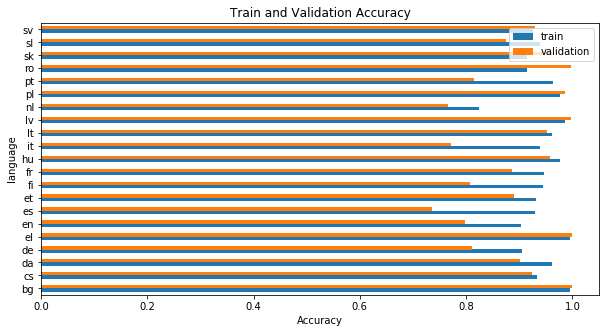

In [360]:
df_total = df_training_set.merge(df_validation,on='index')
df_total.columns = ['language','train','validation']

df_total.plot(x = 'language',kind='barh',figsize = (10,5))
plt.xlabel('Accuracy')
plt.title('Train and Validation Accuracy')